# Analýza dat slonů

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.gridspec as gridspec
from scipy.stats import mode
import os
import sys

# PATH TRICK
sys.path.append('..')
from visualize.read_positions import read_positions



In [40]:
sns.set_style("darkgrid")

palette = sns.color_palette("hls", 5)
sns.set_palette(palette)

In [41]:
df = read_positions(label_dir='../data_all/labels', output_csv='positions.csv')

# Exclude for consistency
dates_to_exclude = [pd.to_datetime('2024-01-21').date(), pd.to_datetime('2024-01-22').date(), pd.to_datetime('2024-01-23').date()]

df = df[~df['Date'].dt.date.isin(dates_to_exclude)]
df.head(11)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 8087
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Camera    7720 non-null   int64         
 1   Date      7720 non-null   datetime64[ns]
 2   X_center  7720 non-null   float64       
 3   Y_center  7720 non-null   float64       
 4   Width     7720 non-null   float64       
 5   Height    7720 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 422.2 KB


In [42]:
df.drop(columns=['X_center', 'Y_center', 'Width' , 'Height'], inplace=True)

### Rozložení počtu slonů 

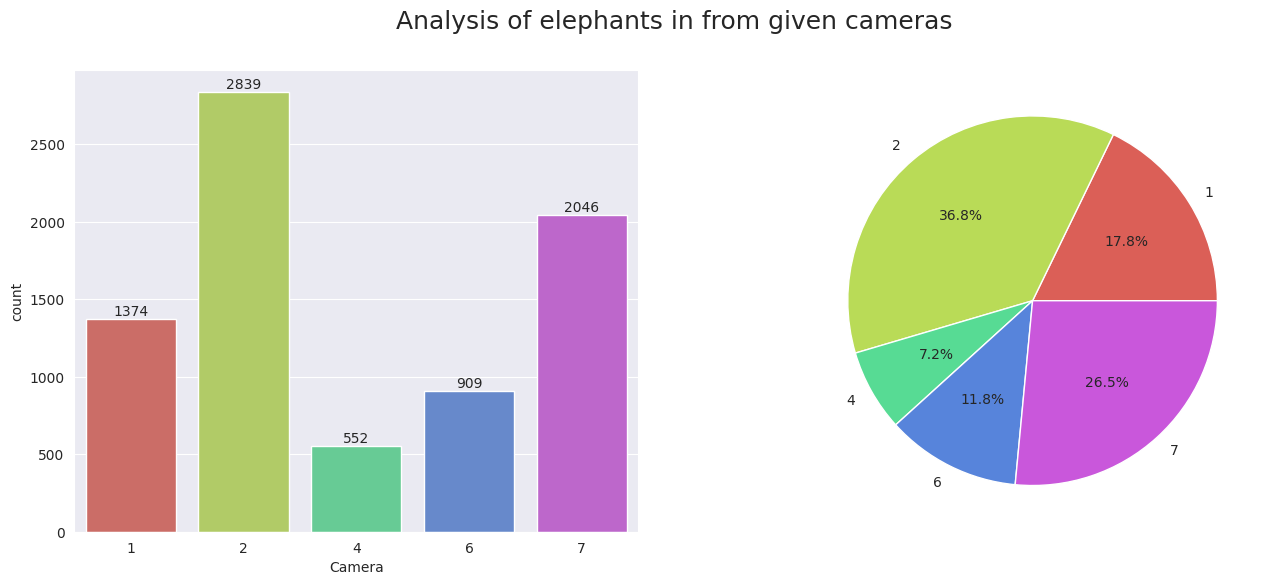

In [43]:
# Inspired from 4th notebook of BI-VIZ course
def univariate_cat_dt(df, column, title):
    stats_df = pd.DataFrame(data={
        'Frequency': df[column].value_counts(),
        'Relative frequency': df[column].value_counts(normalize=True) 
    })
    stats_df.sort_index(inplace=True)
    mode = pd.DataFrame(np.array([
        ["Mode", df[column].mode()[0]], 
    ]), columns=['Name', 'Value'])    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    fig.suptitle(title, fontsize = 18)
    sns.countplot(data=df, x=column, ax=ax1, palette=palette, hue=column)
    
    for container in ax1.containers:
        ax1.bar_label(container)
    ax1.legend().set_visible(False)

    
    ax2.pie(stats_df['Frequency'], labels=stats_df.index, autopct='%1.1f%%')
    plt.show()
    

univariate_cat_dt(df, 'Camera', 'Analysis of elephants in from given cameras')

### Průměrné Množství slonů na jednotlivých kamerách podle hodiny

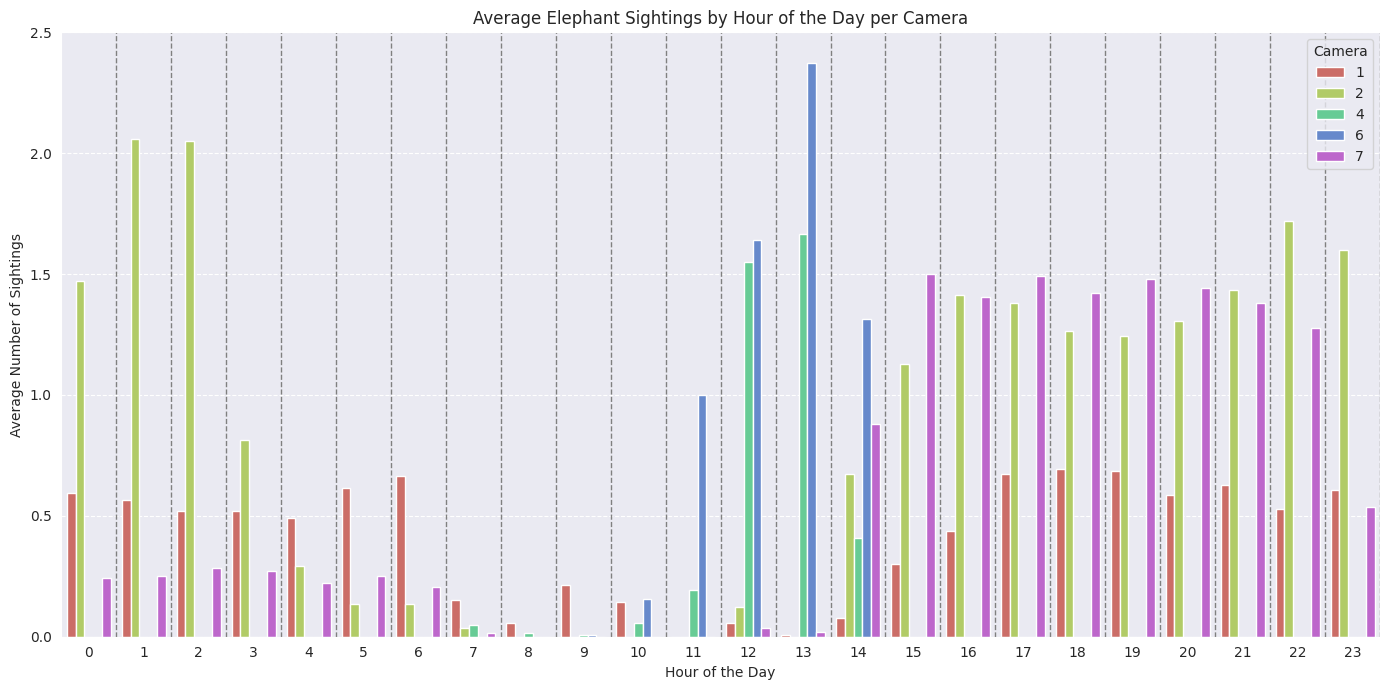

In [44]:
# Calculate the number of unique days to find the divisor for averaging
df['Hour'] = df['Date'].dt.hour
num_days = df['Date'].dt.date.nunique()
hourly_sightings = df.groupby(['Hour', 'Camera']).size().unstack(fill_value=0) / num_days /4

hourly_sightings_melted = hourly_sightings.reset_index().melt(id_vars='Hour', var_name='Camera', value_name='Average Sightings')

# Adjusting the graph with wider separators
plt.figure(figsize=(14, 7))
sns.barplot(x='Hour', y='Average Sightings', hue='Camera', data=hourly_sightings_melted, dodge=True, palette=sns.color_palette("hls", len(hourly_sightings.columns)))
for hour in range(0, 24):
    plt.axvline(x=hour + 0.5, color='grey', linestyle='--', linewidth=1)

plt.title('Average Elephant Sightings by Hour of the Day per Camera')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Sightings')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.legend(title='Camera', loc='upper right')
plt.yticks(np.arange(0,3,0.5))

plt.tight_layout()
plt.show()


### Maximální průměrné množství slonů pro každou hodinu podle dne v týdnu.
Každý sloupec v časovém okně představuje jeden den od pondělí do neděle.
Z grafu se dá vykoukat jistá variabilita v rámci jednotlivých dnů.

/tmp/ipykernel_101841/3245174943.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_camera = df.groupby(['Hour', 'Weekday', 'Camera']).size().reset_index(name='Sightings')
/tmp/ipykernel_101841/3245174943.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_avg_sightings = grouped_by_camera.loc[grouped_by_camera.groupby(['Hour', 'Weekday'])['Average Sightings Per Day'].idxmax()]


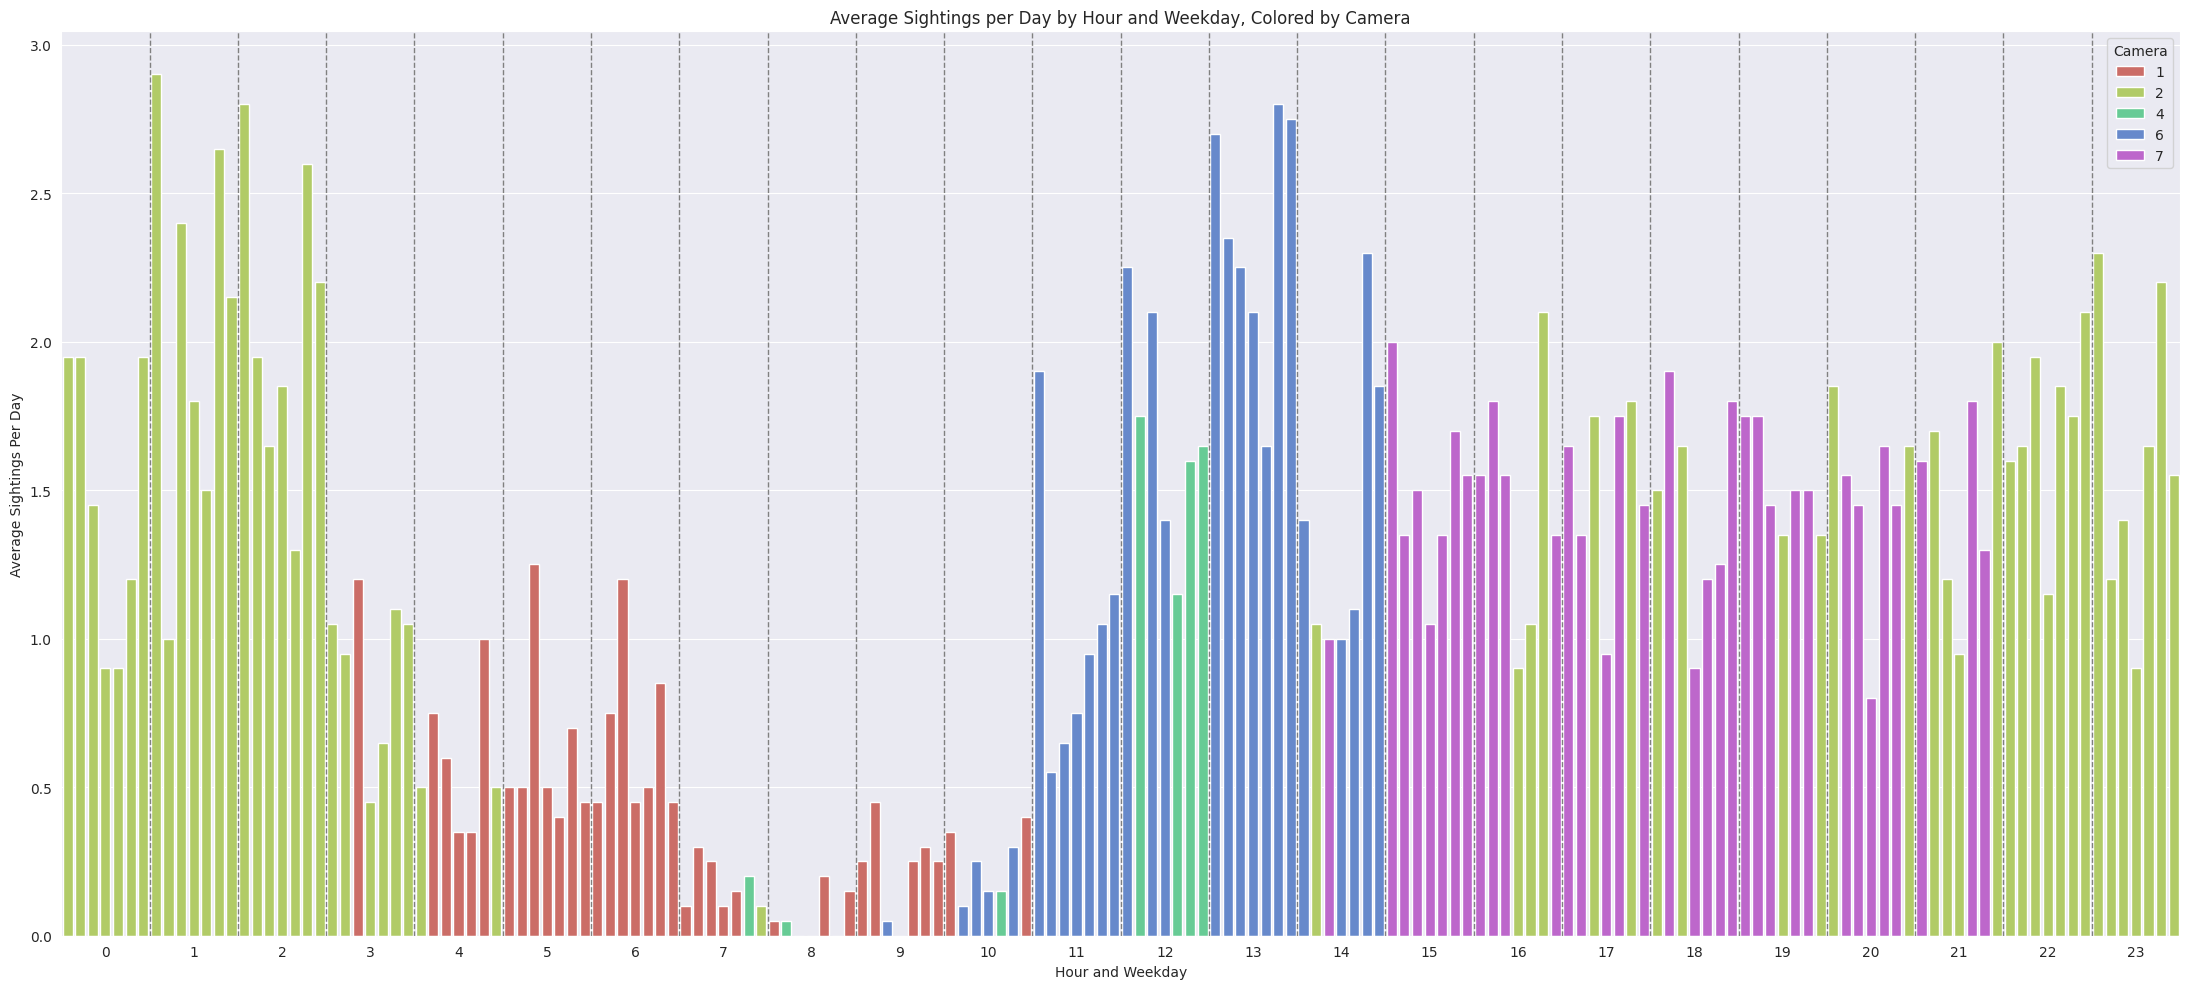

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preparation steps
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)

grouped_by_camera = df.groupby(['Hour', 'Weekday', 'Camera']).size().reset_index(name='Sightings')

weeks = 5
grouped_by_camera['Average Sightings Per Day'] = grouped_by_camera['Sightings'] / weeks /4

max_avg_sightings = grouped_by_camera.loc[grouped_by_camera.groupby(['Hour', 'Weekday'])['Average Sightings Per Day'].idxmax()]

max_avg_sightings['Hour-Weekday'] = max_avg_sightings['Hour'].astype(str) + '-' + max_avg_sightings['Weekday'].astype(str)

# Plotting
plt.figure(figsize=(22, 10))
sns.barplot(x='Hour-Weekday', y='Average Sightings Per Day', hue='Camera', data=max_avg_sightings, dodge=False, palette=sns.color_palette("hls", df['Camera'].nunique()))

unique_hours = sorted(max_avg_sightings['Hour'].unique())
# Shift for labels
label_positions = [(unique_hours.index(hour) * 7 + 3) for hour in unique_hours] 

plt.xticks(ticks=label_positions, labels=unique_hours, rotation=90)

for pos in label_positions[:-1]:  
    plt.axvline(x=pos + 3.5, color='grey', linestyle='--', linewidth=1) 

plt.title('Average Sightings per Day by Hour and Weekday, Colored by Camera')
plt.xlabel('Hour and Weekday')
plt.ylabel('Average Sightings Per Day')
plt.xticks(rotation=0)

plt.legend(title='Camera', loc='upper right')
plt.tight_layout()
plt.show()


In [46]:
# import pandas as pd
# import numpy as np
# import seaborn as snsa
# import matplotlib.pyplot as plt

# # Assuming df is already loaded and prepared with 'Hour' and 'Weekday'
# df['Date'] = pd.to_datetime(df['Date'])
# df['Hour'] = df['Date'].dt.hour
# df['Weekday'] = df['Date'].dt.dayofweek
# df['Day Type'] = df['Weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Workday')

# # Convert 'Day Type' into a categorical type with a defined order
# df['Day Type'] = pd.Categorical(df['Day Type'], categories=['Workday', 'Weekend'], ordered=True)

# # Group the data by 'Hour', 'Day Type', and 'Camera', counting sightings
# grouped_by_camera_day_type = df.groupby(['Hour', 'Day Type', 'Camera']).size().reset_index(name='Sightings')

# # Fix: Ensure 'Days' column calculation does not involve any categorical type inadvertently
# # Calculate days based on 'Day Type' string value rather than the categorical type to avoid the division error
# grouped_by_camera_day_type['Days'] = grouped_by_camera_day_type['Day Type'].map({'Workday': 25, 'Weekend': 10}).astype(float)
# grouped_by_camera_day_type['Average Sightings Per Day'] = grouped_by_camera_day_type['Sightings'] / grouped_by_camera_day_type['Days']

# # Finding the maximum average sighting for each "Hour-Day Type" combination
# max_avg_sightings_day_type = grouped_by_camera_day_type.loc[grouped_by_camera_day_type.groupby(['Hour', 'Day Type'])['Average Sightings Per Day'].idxmax()]

# # Create a 'Hour-Day Type' identifier for plotting, directly using 'Day Type' string values
# max_avg_sightings_day_type['Hour-Day Type'] = max_avg_sightings_day_type['Hour'].astype(str) + '-' + max_avg_sightings_day_type['Day Type'].astype(str)

# # Plotting
# plt.figure(figsize=(14, 7))
# sns.barplot(x='Hour-Day Type', y='Average Sightings Per Day', hue='Camera', data=max_avg_sightings_day_type, dodge=False, palette=sns.color_palette("hls", df['Camera'].nunique()))


# unique_hours = sorted(max_avg_sightings_day_type['Hour'].unique())
# label_positions = [(unique_hours.index(hour) * 2 + 0.5) for hour in unique_hours]  # Assuming 7 weekdays per hour group, +3 centers the label
# plt.xticks(ticks=label_positions, labels=unique_hours, rotation=0)
# for pos in label_positions[:-1]:  
#     plt.axvline(x=pos + 1, color='grey', linestyle='--', linewidth=1.5) 
# plt.xticks(rotation=0)

# plt.title('Average Sightings per Day by Hour and Day Type, Colored by Camera')
# plt.xlabel('Hour of the Day')
# plt.ylabel('Average Sightings Per Day')

# plt.legend(title='Camera', loc='upper right')
# plt.tight_layout()
# plt.show()


### Testové statistiky
Na základě daných grafů je dobré ověřit jisté testové statistiky

In [47]:
import scipy.stats as stats
data = df.copy()

#### **Testování nezávisloti výskytu slonů na kamerách v závislosti na čase**

In [48]:

data['Hour'] = data['Date'].dt.hour

hour_camera_contingency = pd.crosstab(data['Hour'], data['Camera'])
hour_camera_contingency = hour_camera_contingency/num_days
hour_camera_contingency

Camera,1,2,4,6,7
Hour,,,,,
0,2.371429,5.885714,0.000000,0.000000,0.971429
1,2.257143,8.228571,0.000000,0.000000,1.000000
2,2.085714,8.200000,0.000000,0.000000,1.142857
3,2.085714,3.257143,0.000000,0.000000,1.085714
4,1.971429,1.171429,0.000000,0.000000,0.885714
5,2.457143,0.542857,0.000000,0.000000,1.000000
6,2.657143,0.542857,0.000000,0.000000,0.828571
7,0.600000,0.142857,0.200000,0.000000,0.057143
8,0.228571,0.000000,0.057143,0.000000,0.000000


Provedeme Pearsonův $\chi^2$ test nezávislosti s hladinou významnosti 5 %.

- $H_0$:  $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$:  neplatí $H_0$


In [49]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(hour_camera_contingency)

print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')

Chi-Square Statistic: 241.64942570556252
P-Value: 2.2119870297040636e-15
Degrees of Freedom: 92


Na standardní hladině zamítáme ve prospěch alternativy, tedy výskyt slonů je významně ovlivněný časovou dobu.

#### **Testování nezávisloti výskytu slonů venku a vevnitř v závislosti na čase**
Opět využití Pearsonova $\chi^2$ testu.

- $H_0$:  $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$:  neplatí $H_0$

In [50]:
data['Location'] = data['Camera'].apply(lambda x: 'Outside' if x in [4, 6] else 'Inside')

hour_camera_contingency = pd.crosstab(data['Hour'], data['Location'])
hour_camera_contingency = hour_camera_contingency/num_days

chi2_stat, p_val, dof, expected = stats.chi2_contingency(hour_camera_contingency)
print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')

Chi-Square Statistic: 188.85552824824424
P-Value: 5.059736379377774e-28
Degrees of Freedom: 23


Na standardní hladině zamítáme ve prospěch alternativy, tedy venku či vevnitř je významně ovlivněný časovou dobu.

#### **Testování hypotézy, zda jich je slonů mezi $12-14$ významně více venku**

Agregujeme si do tabulky dvě veličiny počtu slonů viděných na vnitřních kamerách oproti počtu ve venkovních.

Použití párového t-testu vyžaduje normalitu rozdílů sledovaných veličin.

Použijeme Shapiro-Wilkův test pro ověření hypotézy o normalitě.

- $H_0$: Rozdíl veličin pochází z náhodného rozdělení
- $H_A$: neplatí $H_0$

In [51]:
filtered_data = data[(data['Hour'] >= 12) & (data['Hour'] < 14)]
grouped_data = data.groupby([filtered_data['Date'], 'Location']).size().unstack(fill_value=0)
w_stat, p_val = stats.shapiro(grouped_data['Inside'] - grouped_data['Outside'])

print("W-Statistic:", w_stat)
print("P-Value:", p_val)

W-Statistic: 0.8964443398766632
P-Value: 3.0252688940034446e-11


Na standardní hladině zamítáme normalitu rozdílu daných veličin.
Místo párového t-testu využijeme jeho neparametrickou verzi tedy párový Wilcoxonův test.

- $H_0$: $EZ = 0$
- $H_A$: $EZ < 0$

In [52]:
adjusted_t_stat, adjusted_p_val = stats.wilcoxon(grouped_data['Inside'], grouped_data['Outside'], alternative='less')  

print("Adjusted T-Statistic:", adjusted_t_stat)
print("Adjusted P-Value:", adjusted_p_val)

Adjusted T-Statistic: 214.0
Adjusted P-Value: 3.3131167887357384e-37


Na standardní hladině zamitáme ve prospěch alt., tedy slonů je venku mezi 12-14 významně více.